In [1]:
import os
import pickle

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

mpl.rc('font', family='Times New Roman')

Paths to directories

In [2]:
# Directory containing results
results_dir = os.path.join(os.path.curdir, os.path.pardir, '2_updating_strategy', 'modules', 'output')

Get summary of all scenarios for which model has been run.

In [3]:
def get_run_summaries(results_dir):
    """Collate information summarising the parameters used in each run
    
    Parameters
    ----------
    results_dir : str
        Directory containing model output
    
    
    Returns
    -------
    run_summaries : dict
        Dictionary summarising model parameterisations    
    """
    
    # Find all results summary files
    run_summary_files = [i for i in os.listdir(results_dir) if 'run_summary' in i]

    # Container for dictionaries summarising model runs
    run_summaries = dict()

    # Open each run summary file and compile in a single dictionary
    for i in run_summary_files:
        with open(os.path.join(results_dir, i), 'rb') as f:
            # Load run summary from file
            run_summary = pickle.load(f)
            
            # Append to dictionary collating all run summaries
            run_summaries = {**run_summaries, **run_summary}
            
    return run_summaries

# Summary of parameters used for each run
run_summaries = pd.DataFrame.from_dict(get_run_summaries(results_dir), orient='index')

In [4]:
# Correct typo in case description ('uanticipated' should be 'unanticipated')
# run_summaries.loc['1496BFFB', 'description'] = 'Revenue rebalance update - revenue neutral - unanticipated emissions intensity shock - imperfect forecast'

In [5]:
for index, row in run_summaries.iterrows():
    print(index, row['description'])

128D8CFA Revenue rebalance update - positive_revenue_target - no shocks - perfect forecast
1E69905B MPC update - revenue neutral - intermittent renewables become eligible - imperfect forecast
28F104BD Revenue rebalance update - revenue neutral - no shocks - imperfect forecast
40310870 carbon tax - no shocks
43B295A9 MPC update - positive_revenue_target - emissions intensity shock - perfect forecast
4AB48A69 Revenue rebalance update - revenue neutral - anticipated emissions intensity shock - imperfect forecast
5333904A MPC update - revenue neutral - no shocks - perfect forecast
6E0412AC Revenue rebalance update - positive_revenue_target - emissions intensity shock - perfect forecast
823F7609 MPC update - positive revenue target - no shocks - imperfect forecast
91EAD3B7 MPC update - revenue neutral - unanticipated emissions intensity shock - imperfect forecast
99142E56 MPC update - revenue neutral - no shocks - imperfect forecast
9D213D85 MPC update - revenue neutral - anticipated emissi

7FAD8604 MPC update - revenue neutral - unanticipated emissions intensity shock - imperfect forecast
1C0E7396 MPC update - revenue neutral - anticipated emissions intensity shock - imperfect forecast

In [6]:
def is_revenue_neutral(revenue_target):
    """Check if case is revenue neutral
    
    Parameters
    ----------
    revenue_target : dict or None
        Defines revenue target for each period.
        Note: Will be None when running benchmark cases
    
    Returns
    -------
    revenue_neutral : bool
        True = target scheme revenue is 0 for all periods
        False = Non-zero scheme revenue target for at least one period    
    """
    
    # Check if revenue target is None
    if revenue_target is None:
        revenue_neutral = None
        
    elif revenue_target is not None:
        
        # Check if revenue target for all periods = 0
        revenue_neutral =  all([True if revenue_target[i][j] == 0 else False 
                                for i in revenue_target.keys() 
                                for j in revenue_target[i].keys()])
    
    # If revenue target is None, return False
    else:
        revenue_neutral = False
    
    return revenue_neutral


def renewables_become_eligible(renewables_eligible):
    """Check if renewables become eligible to receive payments
    
    Parameters
    ----------
    renewables_eligibile : dict or None
        Defines if renewables are eligible for payments in each period
        Note: Will be None when running benchmark cases
    
    Returns
    -------
    renewables_are_eligible : bool
        True = renewables are eligible for payments in at least one week
        False = renewables are ineligible for payments for all weeks    
    """
    
    # Check if input is type None
    if renewables_eligible is None:
        renewables_are_eligible = None
        
    elif renewables_eligible is not None:
        # Check if renewabes are eligible for payments in at least one week
        renewables_are_eligible = any([renewables_eligible[i][j] 
                                       for i in renewables_eligible.keys() 
                                       for j in renewables_eligible[i].keys()])
    
    # Renewables don't receive payments in any week, return False
    else:
        renewables_are_eligible = False
    
    return renewables_are_eligible


def get_case_run_id(update_mode, shock_option, anticipated_shock, forecast_uncertainty_increment, 
                    revenue_neutral, renewables_eligible):
    """Given case parameters, find run_id corresponding to case
    
    Parameters
    ----------
    update_mode : str
        Type of baseline updating used
        Options - NO_UPDATE, MPC_UPDATE, REVENUE_REBALANCE_UPDATE
    
    shock_option : str
        Type of shock subjected to model
        Options - NO_SHOCK, EMISSIONS_INTENSITY_SHOCK
    
    anticipated_shock : bool or None
        Denotes if shock was anticipated. Use None if no shock (i.e. not applicable)
        
    forecast_uncertainty_increment : float
        Scaling factor used when perturbing forecasts
    
    revenue_neutral : bool
        Defines if revenue neutral target employed. True = revenue neutral target,
        False = Non-revenue neutral target
    
    renewables_eligible : bool
        Defines if renewables are eligibile for emissions payments 
        
    
    Returns
    -------
    run_id : str
        ID of case which satisfies given criteria
    """
    
    # Check that update mode and shock_option are valid
    if update_mode not in ['NO_UPDATE', 'MPC_UPDATE', 'REVENUE_REBALANCE_UPDATE']:
        raise(Exception(f'Unexpected update_mode specified: {update_mode}'))
    
    if shock_option not in ['NO_SHOCKS', 'EMISSIONS_INTENSITY_SHOCK']:
        raise(Exception(f'Unexpected shock_option specified: {shock_option}'))
        
    # Check if shock was anticipated or not (or if not applicable in which case
    # anticipated shock = None).
    if anticipated_shock is None:
        description_filter_1 = ''
    
    elif anticipated_shock:
        description_filter_1 = ' anticipated'
    
    else:
        description_filter_1 = ' unanticipated'


    # run_summaries.loc[(run_summaries['update_mode'] == update_mode) and ]
    mask = run_summaries.apply(lambda x: (x['shock_option'] == shock_option)
                               and (x['update_mode'] == update_mode)
                               and (x['forecast_uncertainty_increment'] == forecast_uncertainty_increment)
                               and (is_revenue_neutral(x['target_scheme_revenue']) == revenue_neutral)
                               and (renewables_become_eligible(x['intermittent_generators_regulated']) == renewables_eligible)
                               and (description_filter_1 in x['description']), axis=1)

    if len(run_summaries.loc[mask].index) != 1:
        raise(Exception(f'Should only return 1 run_id, returned : {run_summaries.loc[mask].index}'))

    return run_summaries.loc[mask].index[0]


def get_case_run_id_by_description(description):
    """Given description text, get run ID for given case
    
    Parameters
    ----------
    description : str
        String used to describe case
    
    Returns
    -------
    run_id : str
        Run ID for the described case    
    """
    
    # All IDs corresponding to the given case description
    mask = run_summaries['description']==description
    ids = run_summaries.loc[mask].index
    
    if len(ids) != 1:
        raise(Exception(f'Should only return 1 run_id, returned : {run_summaries.loc[mask].index}'))
    
    return run_summaries.loc[mask].index[0]
    

def get_case_data(run_id, series_name):
    """Extract data for given run_id and series_name
    
    Parameters
    ----------
    run_id : str
        ID of case for which data should be extracted
    
    series_name : str
        Name of series for which data should be extracted
    
    
    Returns
    -------
    index : list
        Series index
    
    values : list
        Series values  
    """
    
    with open(os.path.join(results_dir, f'{run_id}_week_metrics.pickle'), 'rb') as f:
        week_metrics = pickle.load(f)
        
    index, values = list(week_metrics[series_name].keys()), list(week_metrics[series_name].values())

    return index, values

In [7]:
# Emissions intensity
# -------------------
# Run ID
r0 = get_case_run_id_by_description(description='carbon tax - no shocks')

# Baseline
x_e0, y_e0 = get_case_data(run_id=r0, series_name='average_emissions_intensity_regulated_generators')


# Revenue neutral case - no shocks - revenue re-balancing update
# --------------------------------------------------------------
# Run ID
r1 = get_case_run_id(update_mode='REVENUE_REBALANCE_UPDATE', shock_option='NO_SHOCKS', anticipated_shock=None, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=True, renewables_eligible=False)
# Baseline
x_b1, y_b1 = get_case_data(run_id=r1, series_name='baseline')

# Rolling scheme revenue
x_r1, y_r1 = get_case_data(run_id=r1, series_name='rolling_scheme_revenue_interval_end')


# Revenue neutral case - no shocks - MPC
# --------------------------------------
# Run ID
r2 = get_case_run_id(update_mode='MPC_UPDATE', shock_option='NO_SHOCKS', anticipated_shock=None, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=True, renewables_eligible=False)
# Baseline
x_b2, y_b2 = get_case_data(run_id=r2, series_name='baseline')

# Rolling scheme revenue
x_r2, y_r2 = get_case_data(run_id=r2, series_name='rolling_scheme_revenue_interval_end')



# Revenue target case - no shocks - revenue re-balancing update
# --------------------------------------------------------------
# Run ID
r3 = get_case_run_id(update_mode='REVENUE_REBALANCE_UPDATE', shock_option='NO_SHOCKS', anticipated_shock=None, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=False, renewables_eligible=False)
# Baseline
x_b3, y_b3 = get_case_data(run_id=r3, series_name='baseline')

# Rolling scheme revenue
x_r3, y_r3 = get_case_data(run_id=r3, series_name='rolling_scheme_revenue_interval_end')


# Revenue target case - no shocks - MPC
# --------------------------------------
# Run ID
r4 = get_case_run_id(update_mode='MPC_UPDATE', shock_option='NO_SHOCKS', anticipated_shock=None, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=False, renewables_eligible=False)
# Baseline
x_b4, y_b4 = get_case_data(run_id=r4, series_name='baseline')

# Rolling scheme revenue
x_r4, y_r4 = get_case_data(run_id=r4, series_name='rolling_scheme_revenue_interval_end')



# Emissions intensity shock
# -------------------------
# Emissions intensity 
# -------------------
# Run ID
r5 = get_case_run_id_by_description(description='carbon tax - emissions intensity shock')

# Baseline
x_e5, y_e5 = get_case_data(run_id=r5, series_name='average_emissions_intensity_regulated_generators')


# Revenue neutral case - emissions intensity shock - revenue re-balancing update
# ------------------------------------------------------------------------------
# Run ID
r6 = get_case_run_id(update_mode='REVENUE_REBALANCE_UPDATE', shock_option='EMISSIONS_INTENSITY_SHOCK', anticipated_shock=True, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=True, renewables_eligible=False)
# Baseline
x_b6, y_b6 = get_case_data(run_id=r6, series_name='baseline')

# Rolling scheme revenue
x_r6, y_r6 = get_case_data(run_id=r6, series_name='rolling_scheme_revenue_interval_end')


# Revenue neutral case - emissions intensity shock - MPC
# ------------------------------------------------------
# Run ID
r7 = get_case_run_id(update_mode='MPC_UPDATE', shock_option='EMISSIONS_INTENSITY_SHOCK', anticipated_shock=True, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=True, renewables_eligible=False)
# Baseline
x_b7, y_b7 = get_case_data(run_id=r7, series_name='baseline')

# Rolling scheme revenue
x_r7, y_r7 = get_case_data(run_id=r7, series_name='rolling_scheme_revenue_interval_end')


# Revenue target case - emissions intensity shock - revenue re-balancing update
# -----------------------------------------------------------------------------
# Run ID
r8 = get_case_run_id(update_mode='REVENUE_REBALANCE_UPDATE', shock_option='EMISSIONS_INTENSITY_SHOCK', anticipated_shock=False, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=True, renewables_eligible=False)
# Baseline
x_b8, y_b8 = get_case_data(run_id=r8, series_name='baseline')

# Rolling scheme revenue
x_r8, y_r8 = get_case_data(run_id=r8, series_name='rolling_scheme_revenue_interval_end')


# Revenue target case - emissions intensity shock - MPC
# -----------------------------------------------------
# Run ID
r9 = get_case_run_id(update_mode='MPC_UPDATE', shock_option='EMISSIONS_INTENSITY_SHOCK', anticipated_shock=False, 
                     forecast_uncertainty_increment=0.05, revenue_neutral=True, renewables_eligible=False)
# Baseline
x_b9, y_b9 = get_case_data(run_id=r9, series_name='baseline')

# Rolling scheme revenue
x_r9, y_r9 = get_case_data(run_id=r9, series_name='rolling_scheme_revenue_interval_end')

<Figure size 432x288 with 0 Axes>

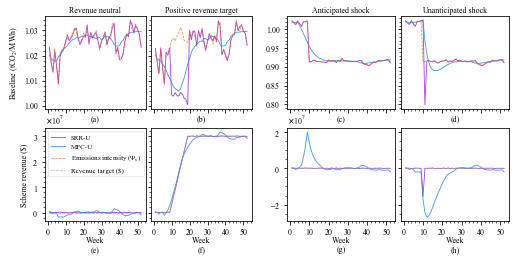

In [19]:
plt.clf()
# fig, axs = plt.subplots(nrows=2, ncols=4, sharex='col')
fig = plt.figure()

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.07, right=0.48, top=0.95, wspace=0.05)

gs2 = gridspec.GridSpec(2, 2)
gs2.update(left=0.55, right=0.99, top=0.95, wspace=0.05)

# Parameters
# ----------
# Revenue re-balancing
revenue_rebalancing_format = {'color': '#9721ce', 'linewidth': 0.9, 'alpha': 0.8}

# MPC colour
mpc_format = {'color': '#2084e8', 'linewidth': 0.9, 'alpha': 0.8}

# Emissions intensity 
emissions_intensity_format = {'color': '#e85c20', 'linewidth': 0.7, 'alpha': 0.8, 'linestyle': '--'}

# Revenue target format
revenue_target_format = {'color': '#a0a0a0', 'linewidth': 0.8, 'linestyle': '--', 'alpha': 0.7}

# Revenue neutral
# ---------------
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[1, 0])

# Revenue rebalancing
# -------------------
# Baseline
l1, = ax1.plot(x_b1, y_b1, **revenue_rebalancing_format)

# Scheme revenue
ax2.plot(x_r1, y_r1, **revenue_rebalancing_format)

# MPC update
# ----------
# Baseline
l2, = ax1.plot(x_b2, y_b2, **mpc_format)

# Scheme revenue
ax2.plot(x_r2, y_r2, **mpc_format)

# Emissions intensity
l3, = ax1.plot(x_e0, y_e0, **emissions_intensity_format)


# Revenue target
# --------------
ax3 = plt.subplot(gs1[0, 1], sharey=ax1)
ax4 = plt.subplot(gs1[1, 1], sharey=ax2)

# Revenue rebalancing
# -------------------
# Baseline
ax3.plot(x_b3, y_b3, **revenue_rebalancing_format)

# Scheme revenue
ax4.plot(x_r3, y_r3, **revenue_rebalancing_format)

# MPC update
# ----------
# Baseline
ax3.plot(x_b4, y_b4, **mpc_format)

# Scheme revenue
ax4.plot(x_r4, y_r4, **mpc_format)

# Emissions intensity
ax3.plot(x_e0, y_e0, **emissions_intensity_format)


# Emissions intensity shock
# -------------------------
ax5 = plt.subplot(gs2[0, 0])
ax6 = plt.subplot(gs2[1, 0])

# Revenue rebalancing
# -------------------
# Baseline
ax5.plot(x_b6, y_b6, **revenue_rebalancing_format)

# Scheme revenue
ax6.plot(x_r6, y_r6, **revenue_rebalancing_format)

# MPC update
# ----------
# Baseline
ax5.plot(x_b7, y_b7, **mpc_format)

# Scheme revenue
ax6.plot(x_r7, y_r7, **mpc_format)

# Emissions intensity
ax5.plot(x_e5, y_e5, **emissions_intensity_format)


# Emissions intensity shock
# -------------------------
ax7 = plt.subplot(gs2[0, 1], sharey=ax5)
ax8 = plt.subplot(gs2[1, 1], sharey=ax6)

# Revenue rebalancing
# -------------------
# Baseline
ax7.plot(x_b8, y_b8, **revenue_rebalancing_format)

# Scheme revenue
ax8.plot(x_r8, y_r8, **revenue_rebalancing_format)

# MPC update
# ----------
# Baseline
ax7.plot(x_b9, y_b9, **mpc_format)

# Scheme revenue
ax8.plot(x_r9, y_r9, **mpc_format)

# Emissions intensity
ax7.plot(x_e5, y_e5, **emissions_intensity_format)


# Add revenue targets
for ax in [ax2, ax6, ax8]:
    ax.plot([1, 52], [0, 0], **revenue_target_format)

# Revenue ramp
l4, = ax4.plot([1, 9, 19, 52], [0, 0, 30e6, 30e6], **revenue_target_format)


# Format ticks
# ------------
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.tick_params(labelsize=8)
    ax.minorticks_on()

minorLocator = MultipleLocator(5)
majorLocator = MultipleLocator(10)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.xaxis.set_major_locator(majorLocator)

    
# Format labels
# -------------
ax1.set_ylabel('Baseline (tCO$_{\mathdefault{2}}$/MWh)', fontsize=8)
ax2.set_ylabel('Scheme revenue (\$)', fontsize=8)

for ax in [ax2, ax4, ax6, ax8]:
    ax.set_xlabel('Week', fontsize=8)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(10, 6)) 
    ax.yaxis.major.formatter._useMathText = True
    
for ax in [ax1, ax3, ax5, ax7]:
    ax.tick_params(labelbottom=False)

ax4.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)
ax7.tick_params(labelleft=False)
ax8.tick_params(labelleft=False)

ax2.ticklabel_format(style='sci', axis='y', scilimits=(10, 6)) 

ax4.yaxis.get_offset_text().set_visible(False)
ax8.yaxis.get_offset_text().set_visible(False)

ax1.set_xlabel('(a)', fontsize=8, labelpad=0.08)
ax2.set_xlabel('Week\n(e)', fontsize=8, labelpad=0.15)
ax3.set_xlabel('(b)', fontsize=8, labelpad=0.08)
ax4.set_xlabel('Week\n(f)', fontsize=8, labelpad=0.15)
ax5.set_xlabel('(c)', fontsize=8, labelpad=0.08)
ax6.set_xlabel('Week\n(g)', fontsize=8, labelpad=0.15)
ax7.set_xlabel('(d)', fontsize=8, labelpad=0.08)
ax8.set_xlabel('Week\n(h)', fontsize=8, labelpad=0.15)

ax1.set_title('Revenue neutral', pad=3, fontsize=8)
ax3.set_title('Positive revenue target', pad=3, fontsize=8)
ax5.set_title('Anticipated shock', pad=3, fontsize=8)
ax7.set_title('Unanticipated shock', pad=3, fontsize=8)

ax2.yaxis.get_offset_text().set_size(8)
ax6.yaxis.get_offset_text().set_size(8)

# ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
legend = ax2.legend([l1, l2, l3, l4], ['SRR-U', 'MPC-U', 'Emissions intensity ($\mathdefault{\Psi_{s}}$)', 'Revenue target (\$)'], fontsize=7, loc='upper left')
legend.get_frame().set_linewidth(0.5)

# Set figure size
width = 17.8
height = 8.8
cm_to_in = 0.393701
fig.set_size_inches(width*cm_to_in, height*cm_to_in)

# fig.subplots_adjust(left=0.07, bottom=0.135, right=0.99, top=0.98, wspace=0.2, hspace=0.2)
fig.savefig('test.png', dpi=800)

plt.show()

Create table

In [9]:
import numpy as np

# BAU - no shocks
mask = (run_summaries['shock_option'] == 'NO_SHOCKS') & (run_summaries['update_mode'] == 'NO_UPDATE') & (run_summaries['initial_permit_price'] == 0)
if len(run_summaries[mask].index) != 1:
    raise(Exception(f'Should only encounter 1 index, encountered:{run_summaries[mask].index}'))
else:
    r10 = run_summaries[mask].index[0]
    
# BAU - emissions intensity shock
mask = (run_summaries['shock_option'] == 'EMISSIONS_INTENSITY_SHOCK') & (run_summaries['update_mode'] == 'NO_UPDATE') & (run_summaries['initial_permit_price'] == 0)
if len(run_summaries[mask].index) != 1:
    raise(Exception(f'Should only encounter 1 index, encountered:{run_summaries[mask].index}'))
else:
    r11 = run_summaries[mask].index[0]

Compute aggregate statistics for each case

In [10]:
# Container for aggregate statistics
table = []

# Compute aggregate statistics for each run
for r in [r0, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11]:
    
    # Import weekly metrics
    with open(os.path.join(results_dir, f'{r}_week_metrics.pickle'), 'rb') as f:
        week_metrics = pickle.load(f)

    # Import run summary for case
    with open(os.path.join(results_dir, f'{r}_run_summary.pickle'), 'rb') as f:
        run_summary = pickle.load(f)

    # Dictionary to contain aggregate statistics for current case being investigated
    output = {}

    # Average weekly energy price
    _, average_energy_price = get_case_data(r, 'average_energy_price')
    output['average_energy_price'] = f'{np.mean(average_energy_price):.2f} ({np.std(average_energy_price):.2f})'

    # Emissions (total)
    _, total_emissions_tCO2 = get_case_data(r, 'total_emissions_tCO2')
    output['total_emissions_tCO2'] = f'{np.sum(total_emissions_tCO2)/1e6:.2f}'

    # Baseline (weekly average)
    _, baseline = get_case_data(r, 'baseline')
    output['baseline'] = f'{np.mean(baseline):.3f} ({np.std(baseline):.3f})'

    # Difference between scheme revenue and target
    try:
        if run_summary[r]['update_mode'] == 'MPC_UPDATE':
            # Total model horizon
            model_horizon = run_summary[r]['model_horizon']

            # Length of MPC forecast interval
            forecast_interval_mpc = run_summary[r]['forecast_interval_mpc']

            # Target scheme revenue used in model
            target_scheme_revenue_dict = run_summary[r]['target_scheme_revenue']

            # Flatten to dict with single key-value pairs
            target_scheme_revenue = {**{i: j[1] for i, j in target_scheme_revenue_dict.items()},
                                     **{model_horizon-forecast_interval_mpc+i: target_scheme_revenue_dict[model_horizon-forecast_interval_mpc+1][i]
                                        for i in range(1, forecast_interval_mpc+1)}
                                    }

        elif run_summary[r]['update_mode'] == 'REVENUE_REBALANCE_UPDATE':
            # Only a single forecast for rebalancing update
            target_scheme_revenue = {i: j[1] for i, j in run_summary[r]['target_scheme_revenue'].items()}

        # Compute difference between accrued scheme revenue and target for each week
        revenue_difference = pd.Series(target_scheme_revenue).subtract(pd.Series(week_metrics['rolling_scheme_revenue_interval_end']))

        # Add to dictionary
        output['revenue_difference'] = f'{revenue_difference.mean()/1e6:.2f} ({revenue_difference.div(1e6).std():.2f})'

    except:
        output['revenue_difference'] = '-'

    # Type of shock
    output['shock_option'] = run_summary[r]['shock_option']
    
    # Model description
    output['description'] = run_summary[r]['description']
    
    # Model run ID
    output['run_id'] = r

    # Append to main container
    table.append(output)

Create tables to be used in manuscript

In [11]:
# Construct table containing aggregated statistics
df_table = pd.DataFrame(table)

# Map case description to tuple which will define new index
description_map = {'carbon tax - no shocks': ('Carbon tax', 'No shock'),
                   'Revenue rebalance update - revenue neutral - no shocks - imperfect forecast': ('Revenue neutral', 'RR'),
                   'MPC update - revenue neutral - no shocks - imperfect forecast': ('Revenue neutral', 'MPC'),
                   'Revenue rebalance update - positive revenue target - no shocks - imperfect forecast': ('Revenue target', 'RR'),
                   'MPC update - positive revenue target - no shocks - imperfect forecast': ('Revenue target', 'MPC'),
                   'business as usual - no shocks': ('BAU', 'No shock'),
                   'carbon tax - emissions intensity shock': ('Carbon tax', 'shock'),
                   'Revenue rebalance update - revenue neutral - anticipated emissions intensity shock - imperfect forecast': ('Anticipated', 'RR'),
                   'MPC update - revenue neutral - anticipated emissions intensity shock - imperfect forecast': ('Anticipated', 'MPC'),
                   'Revenue rebalance update - revenue neutral - unanticipated emissions intensity shock - imperfect forecast': ('Unanticipated', 'RR'),
                   'MPC update - revenue neutral - unanticipated emissions intensity shock - imperfect forecast': ('Unanticipated', 'MPC'),
                   'business as usual - emissions intensity shock': ('BAU', 'shock'),
                  }

# Get new index based on case description
df_table[['new_index_1', 'new_index_2']] = df_table.apply(lambda x: pd.Series(description_map[x['description']]) if x['description'] in description_map.keys() else pd.Series((10, 20)), axis=1)

# Revenue target results
mask = ['average_energy_price', 'total_emissions_tCO2', 'baseline', 'revenue_difference']
cols = [('BAU', 'No shock'), ('Carbon tax', 'No shock'), ('Revenue neutral', 'RR'), ('Revenue neutral', 'MPC'), ('Revenue target', 'RR'), ('Revenue target', 'MPC')]
new_index = {'average_energy_price': 'Average price ($/MWh)', 'baseline': 'Baseline (tCO2/MWh)', 'revenue_difference': 'Revenue - Target (million $)', 'total_emissions_tCO2': 'Emissions (MtCO2)'}
df1 = df_table.set_index(['new_index_1', 'new_index_2']).T.reindex(mask).loc[:, cols].rename(index=new_index)
df1.to_csv('table_1.csv')

# Emissions intensity shock results
cols = [('BAU', 'shock'), ('Carbon tax', 'shock'), ('Anticipated', 'RR'), ('Anticipated', 'MPC'), ('Unanticipated', 'RR'), ('Unanticipated', 'MPC')]
new_index = {'average_energy_price': 'Average price ($/MWh)', 'baseline': 'Baseline (tCO2/MWh)', 'revenue_difference': 'Revenue - Target (million $)', 'total_emissions_tCO2': 'Emissions (MtCO2)'}
df2 = df_table.set_index(['new_index_1', 'new_index_2']).T.reindex(mask).loc[:, cols].rename(index=new_index)
df2.to_csv('table_2.csv')